In [1]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, lit
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, BooleanType, DoubleType, IntegerType, DateType

In [2]:
spark = SparkSession.builder.appName("BreweryApp").getOrCreate()
spark

In [3]:
product_range_path = './craft_beer_bar_sales/Product_range.csv'
transactions_path = './craft_beer_bar_sales/Transactions.csv'

# Product

In [4]:
product_df = spark.read.csv(product_range_path, header=True)
product_df.show(10, truncate = False)

+------------+-----------+-----------------------------------------------+------------+---------+-----------------+-----+----+
|Product_code|Vendor_code|Name                                           |Retail_price|Base_unit|Country_of_Origin|Size |ABV |
+------------+-----------+-----------------------------------------------+------------+---------+-----------------+-----+----+
|5028        |NULL       |1 Symbiotica Apple 0.375                       |300.0       |Pieces   |Russia           |0.375|4.5 |
|4846        |NULL       |1 Symbiotica Hard Kombucha Renegade Aronia 0.33|200.0       |Pieces   |Russia           |0.33 |3.0 |
|1340        |NULL       |1000 IBU Imperial IPA Barrel l                 |960.0       |Liters   |NULL             |1.0  |9.6 |
|4372        |NULL       |18th Street Brewery                            |NULL        |NULL     |USA              |NULL |NULL|
|4302        |NULL       |18th Street Brewery Deal With The Devil 0.473  |630.0       |Pieces   |USA           

In [5]:
product_df.describe().show()

+-------+------------------+-----------+--------------------+-----------------+---------+-----------------+------------------+------------------+
|summary|      Product_code|Vendor_code|                Name|     Retail_price|Base_unit|Country_of_Origin|              Size|               ABV|
+-------+------------------+-----------+--------------------+-----------------+---------+-----------------+------------------+------------------+
|  count|              5314|       4288|                5314|             4878|     4910|             4205|              4626|              4622|
|   mean|2690.8447497177267|       NULL|                NULL|637.8395018450183|     NULL|             NULL|0.6269174232598252|7.0742730419731865|
| stddev|1543.2178144494967|       NULL|                NULL|504.8950056344766|     NULL|             NULL|0.9532897768176336|2.4579696462642713|
|    min|                10|        35K|1 Symbiotica Appl...|              1.0|     100g|              ???|              0.1

In [6]:
for column in product_df.columns:
    col_cnt = product_df.select(column).distinct().count()
    print(f"Count Distinct {column}: {col_cnt}")

Count Distinct Product_code: 5314
Count Distinct Vendor_code: 272
Count Distinct Name: 5193
Count Distinct Retail_price: 185
Count Distinct Base_unit: 5
Count Distinct Country_of_Origin: 29
Count Distinct Size: 32
Count Distinct ABV: 152


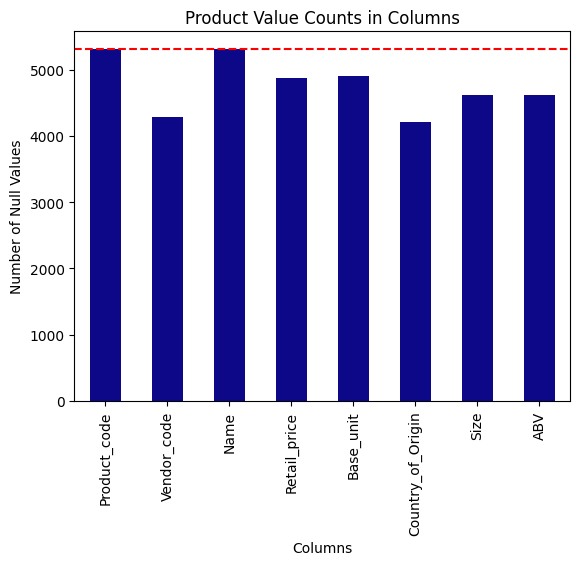

In [7]:
not_null_counts = product_df.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in product_df.columns])
not_null_counts_pandas = not_null_counts.toPandas().transpose()
ax = not_null_counts_pandas.plot(kind="bar", stacked=True, legend=False, colormap="plasma")
plt.title("Product Value Counts in Columns")
plt.xlabel("Columns")
plt.ylabel("Number of Null Values")
plt.axhline(y=product_df.count(), color='red', linestyle='--', label='Upper Limit')
plt.show()

# Transactions

In [8]:
transaction_df = spark.read.csv(transactions_path, header=True)
transaction_df.show(10, truncate = False)

+--------------------------+------------+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+------+-----------+---------------+------+-----------------+-------------------+
|2020-01-01 23:00:00       |144         |1.0   |280.0      |NULL           |155.0 |124.0            |NULL               |
|2020-01-01 23:00:00       |209         |2.0   |545.73     |294.27         |75.73 |16.11            |35.03              |
|2020-01-01 23:00:00       |213         |2.0   |1265.05    |34.95          |653.05|106.71           |2.69               |
|2020-01-01 23:00:00       |217         |1.0   |630.0      |70.0           |220.5 |53.85            |10.0               |
|2020-01-01 23:00:00       |222         |2.0   |1104.75    |195.25         |393.75|55.38            |15.02              |
|2020-01-01 23:00:00    

In [9]:
transaction_df.describe().show()

+-------+--------------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|Date_and_time_of_unloading|      Product_code|            Amount|       Sale_amount|   Discount_amount|            Profit| Percentage_markup|Discount_percentage|
+-------+--------------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|                     50084|             50084|             50084|             50033|             39882|             50070|             48145|              39882|
|   mean|                      NULL| 2153.160031147672|3.5531462542927743|1429.7866767933122|243.76132290256055| 705.9019868184575|109.18451116419139|  17.25131287297584|
| stddev|                      NULL|1367.3577054997945| 5.485805401475245| 2419.585454701753|  405.902060386317|1352.6286110631174|1182.538753302

In [10]:
for column in transaction_df.columns:
    col_cnt = transaction_df.select(column).distinct().count()
    print(f"Count Distinct {column}: {col_cnt}")

Count Distinct Date_and_time_of_unloading: 458
Count Distinct Product_code: 3956
Count Distinct Amount: 617
Count Distinct Sale_amount: 22573
Count Distinct Discount_amount: 17844
Count Distinct Profit: 27942
Count Distinct Percentage_markup: 13926
Count Distinct Discount_percentage: 3630


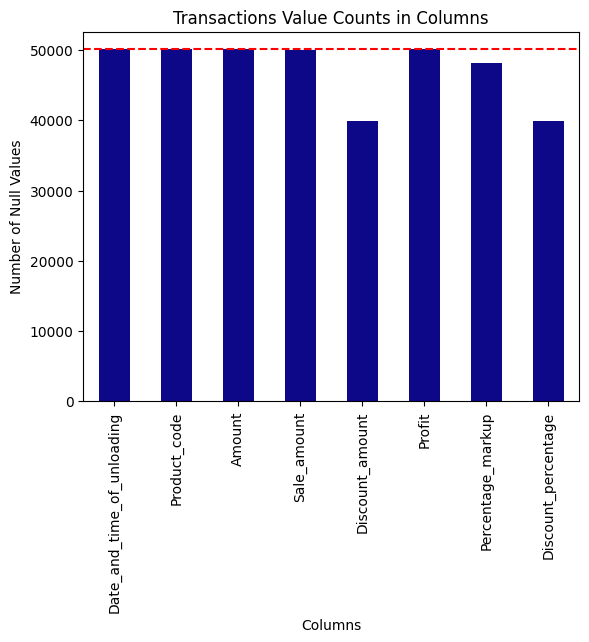

In [11]:
not_null_counts = transaction_df.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in transaction_df.columns])
not_null_counts_pandas = not_null_counts.toPandas().transpose()
ax = not_null_counts_pandas.plot(kind="bar", stacked=True, legend=False, colormap="plasma")
plt.title("Transactions Value Counts in Columns")
plt.xlabel("Columns")
plt.ylabel("Number of Null Values")
plt.axhline(y=transaction_df.count(), color='red', linestyle='--', label='Upper Limit')
plt.show()

# Sales

In [12]:
sales_df = transaction_df\
    .join(product_df, transaction_df['product_code'] == product_df['Product_code'], how="left")\
        .drop(product_df['Product_code'])\
        .select("Date_and_time_of_unloading",  "Product_code",  "Vendor_code",  "Name",  "Retail_price",  "Base_unit",  "Country_of_Origin",  "Size",  "ABV",  "Amount",  "Sale_amount",  "Discount_amount",  "Profit",  "Percentage_markup",  "Discount_percentage")
sales_df.show()

+--------------------------+------------+----------------+--------------------+------------+---------+-----------------+-----+----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|     Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin| Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+----------------+--------------------+------------+---------+-----------------+-----+----+------+-----------+---------------+------+-----------------+-------------------+
|       2020-01-01 23:00:00|         144|         AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|           Russia| 0.33|10.3|   1.0|      280.0|           NULL| 155.0|            124.0|               NULL|
|       2020-01-01 23:00:00|         209|         Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|          Estonia| 0.33| 6.8|   2.0|     545.73|  

# Data Cleaning

In [13]:
print("Total Product Rows:", product_df.count())
print("Total Transactions Rows:", transaction_df.count())
print("Total Sales Rows:", sales_df.count())

Total Product Rows: 5314
Total Transactions Rows: 50084
Total Sales Rows: 50084


In [14]:
inactive_product_count = (
    product_df
    .join(
        transaction_df.select("product_code").distinct(),
        on="product_code",
        how="left_anti"
    )
    .count()
)
print(inactive_product_count)

1358


In [15]:
for column in sales_df.columns:
    col_cnt = sales_df.select(column).distinct().count()
    print(f"Count Distinct {column}: {col_cnt}")

Count Distinct Date_and_time_of_unloading: 458
Count Distinct Product_code: 3956
Count Distinct Vendor_code: 230
Count Distinct Name: 3928
Count Distinct Retail_price: 176
Count Distinct Base_unit: 4
Count Distinct Country_of_Origin: 27
Count Distinct Size: 30
Count Distinct ABV: 144
Count Distinct Amount: 617
Count Distinct Sale_amount: 22573
Count Distinct Discount_amount: 17844
Count Distinct Profit: 27942
Count Distinct Percentage_markup: 13926
Count Distinct Discount_percentage: 3630


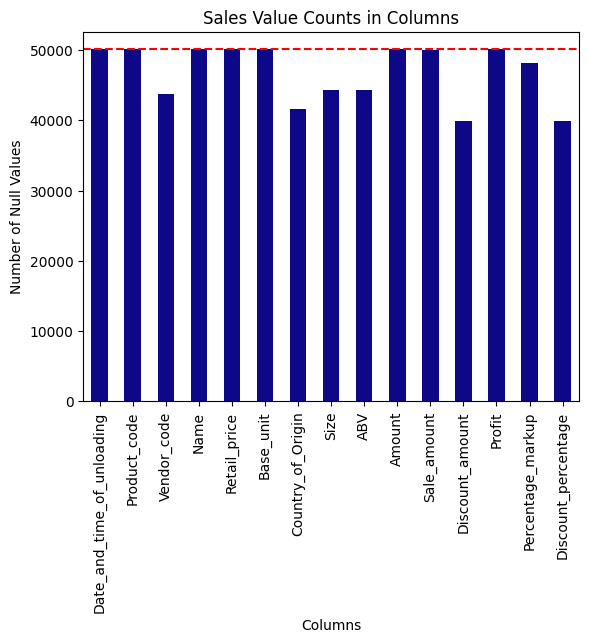

In [16]:
not_null_counts = sales_df.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in sales_df.columns])
not_null_counts_pandas = not_null_counts.toPandas().transpose()
ax = not_null_counts_pandas.plot(kind="bar", stacked=True, legend=False, colormap="plasma")
plt.title("Sales Value Counts in Columns")
plt.xlabel("Columns")
plt.ylabel("Number of Null Values")
plt.axhline(y=sales_df.count(), color='red', linestyle='--', label='Upper Limit')
plt.show()

## Null Values

In [17]:
null_counts = sales_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in sales_df.columns])
null_counts.show()

+--------------------------+------------+-----------+----+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+----+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|                         0|           0|       6324|   0|           3|        0|             8509|5836|5850|     0|         51|          10202|    14|             1939|              10202|
+--------------------------+------------+-----------+----+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+



In [18]:
# Checking the product, this transaction is not beer related row
sales_df.filter(col('Retail_price').isNull()).show()

+--------------------------+------------+-----------+-----------+------------+---------+-----------------+----+----+------+-----------+---------------+--------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|       Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|  Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+-----------+------------+---------+-----------------+----+----+------+-----------+---------------+--------+-----------------+-------------------+
|       2020-06-24 19:00:00|        2395|       NULL|Soft drinks|        NULL|   Pieces|             NULL|NULL|NULL|  50.0|   23249.31|           0.69|23249.31|             NULL|                0.0|
|       2020-12-01 17:00:00|        3046|       NULL|     Snacks|        NULL|   Pieces|             NULL|NULL|NULL|  24.0|    1877.19|         422.81| 1877.19|             NULL|              18.38|
|    

In [19]:
sales_df.filter(col('Name') == 'Snacks').show()

+--------------------------+------------+-----------+------+------------+---------+-----------------+----+----+------+-----------+---------------+-------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|  Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount| Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+------+------------+---------+-----------------+----+----+------+-----------+---------------+-------+-----------------+-------------------+
|       2020-12-01 17:00:00|        3046|       NULL|Snacks|        NULL|   Pieces|             NULL|NULL|NULL|  24.0|    1877.19|         422.81|1877.19|             NULL|              18.38|
|       2020-12-03 19:00:00|        3046|       NULL|Snacks|        NULL|   Pieces|             NULL|NULL|NULL|   8.0|     898.86|         201.14| 898.86|             NULL|              18.29|
+--------------------------+-------

In [20]:
sales_df.filter(col('Vendor_code') == 'Snacks').show(5)

+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|       2020-01-02 01:00:00|         519|     Snacks|Assorted nuts 100 gr|       250.0|   Pieces|             NULL|NULL|NULL|   1.0|      200.0|           NULL| 200.0|             NULL|               NULL|
|       2020-01-02 01:00:00|        1032|     Snacks|Roasted Almonds 100g|       200.0|     100g|           Russia|NULL|NULL|   5.0|     927.18|          72.82|377.18|         

In [21]:
# Snacks Not required
# Remove Vendor_code and Name Snacks
sales_df.groupBy('Vendor_code').count().orderBy('count', ascending = False).show()

+----------------+-----+
|     Vendor_code|count|
+----------------+-----+
|            NULL| 6324|
|            Jaws| 4014|
|         AF Brew| 2756|
|         BrewDog| 2067|
|       Naparbier| 1839|
|         Sobolev| 1507|
|          Snacks| 1241|
| Weihenstephaner| 1197|
|         Bakunin| 1159|
|       Mikkeller| 1103|
|         Saldens|  996|
|      Red Button|  951|
|         Zagovor|  929|
|         XP Brew|  815|
|       Omnipollo|  736|
|           To Ol|  728|
|       Verhaeghe|  709|
|Schneider Weisse|  707|
|         Brewski|  707|
|     Big Village|  660|
+----------------+-----+
only showing top 20 rows



In [22]:
sales_df.filter(col('Name') == 'Soft drinks').show()

+--------------------------+------------+-----------+-----------+------------+---------+-----------------+----+----+------+-----------+---------------+--------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|       Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|  Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+-----------+------------+---------+-----------------+----+----+------+-----------+---------------+--------+-----------------+-------------------+
|       2020-06-24 19:00:00|        2395|       NULL|Soft drinks|        NULL|   Pieces|             NULL|NULL|NULL|  50.0|   23249.31|           0.69|23249.31|             NULL|                0.0|
+--------------------------+------------+-----------+-----------+------------+---------+-----------------+----+----+------+-----------+---------------+--------+-----------------+-------------------+



In [23]:
sales_df = sales_df.filter(
    (col('Vendor_code') != 'Snacks') | 
    (col('Name') != 'Snacks') 
)

In [24]:
sales_df = sales_df.filter(
    (col('Name') != 'Soft drinks')
)

In [25]:
sales_df.filter(col('Vendor_code').isNull()).show()

+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+-------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount| Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+-------+-----------------+-------------------+
|       2020-01-01 23:00:00|        1019|       NULL|Cider Kerisac Bre...|       800.0|   Liters|             NULL| 1.0| 5.0|  0.25|      160.0|           20.0|  81.25|           103.17|              11.11|
|       2020-01-01 23:00:00|        1214|       NULL|Trabanco Sidra Na...|       650.0|   Pieces|             NULL| 0.7| 6.0|   1.0|     419.66|         180.34| 100.16|    

In [26]:
sales_df.filter(col('Country_of_Origin').isNull()).show()

+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|       2020-01-01 23:00:00|         581|    De Noel|Cider sparkling D...|       550.0|   Pieces|             NULL|0.75| 4.5|   5.0|    2032.71|         717.29|615.21|             43.4|              26.08|
|       2020-01-01 23:00:00|        1019|       NULL|Cider Kerisac Bre...|       800.0|   Liters|             NULL| 1.0| 5.0|  0.25|      160.0|           20.0| 81.25|         

In [27]:
sales_df.filter(col('Size').isNull()).show()

+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|       2020-01-02 01:00:00|         364|    Sobolev|      Cheese Stilton|       350.0|   Pieces|           Russia|NULL|NULL|   2.0|      629.9|           70.1| 359.9|            133.3|              10.01|
|       2020-01-02 01:00:00|         380|    Sobolev|Cheese Belper Kno...|       300.0|   Pieces|           Russia|NULL|NULL|   1.0|      300.0|           NULL| 150.0|         

In [28]:
sales_df = sales_df.na.fill("Other",["Vendor_code", "Country_of_Origin"]) 

In [29]:
sales_df = sales_df.drop('Percentage_markup', 'Discount_percentage')
sales_df.show(5)

+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+
|       2020-01-01 23:00:00|         144|    AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|           Russia|0.33|10.3|   1.0|      280.0|           NULL| 155.0|
|       2020-01-01 23:00:00|         209|    Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|          Estonia|0.33| 6.8|   2.0|     545.73|         294.27| 75.73|
|       2020-01-01 23:00:00|         213|    Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|           France| 1.0| 6.0|   2.0|    1265.05|          34.95|

## Casting Columns

In [30]:
sales_df.dtypes

[('Date_and_time_of_unloading', 'string'),
 ('Product_code', 'string'),
 ('Vendor_code', 'string'),
 ('Name', 'string'),
 ('Retail_price', 'string'),
 ('Base_unit', 'string'),
 ('Country_of_Origin', 'string'),
 ('Size', 'string'),
 ('ABV', 'string'),
 ('Amount', 'string'),
 ('Sale_amount', 'string'),
 ('Discount_amount', 'string'),
 ('Profit', 'string')]

In [31]:
sales_df = sales_df\
    .withColumn('Entry_date', col('Date_and_time_of_unloading').cast(DateType()))\
    .drop('Date_and_time_of_unloading')

In [32]:
sales_df = sales_df\
    .withColumn('Retail_price', col('Retail_price').cast(DoubleType()))\
    .withColumn('Size', col('Size').cast(DoubleType()))\
    .withColumn('ABV', col('ABV').cast(DoubleType()))\
    .withColumn('Amount', col('Amount').cast(DoubleType()))\
    .withColumn('Sale_amount', col('Sale_amount').cast(DoubleType()))\
    .withColumn('Discount_amount', col('Discount_amount').cast(DoubleType()))\
    .withColumn('Profit', col('Profit').cast(DoubleType()))

In [33]:
for column in sales_df.dtypes:
    print(column[0],column[1])

Product_code string
Vendor_code string
Name string
Retail_price double
Base_unit string
Country_of_Origin string
Size double
ABV double
Amount double
Sale_amount double
Discount_amount double
Profit double
Entry_date date


In [34]:
sales_df.show()

+------------+----------------+--------------------+------------+---------+-----------------+-----+----+------+-----------+---------------+------+----------+
|Product_code|     Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin| Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Entry_date|
+------------+----------------+--------------------+------------+---------+-----------------+-----+----+------+-----------+---------------+------+----------+
|         144|         AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|           Russia| 0.33|10.3|   1.0|      280.0|           NULL| 155.0|2020-01-01|
|         209|         Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|          Estonia| 0.33| 6.8|   2.0|     545.73|         294.27| 75.73|2020-01-01|
|         213|         Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|           France|  1.0| 6.0|   2.0|    1265.05|          34.95|653.05|2020-01-01|
|         217|          Savoie|Cider Savoie Cidr...|

## Rename Columns

In [35]:
sales_df = sales_df.withColumnsRenamed({
    "Product_code": "pid",
    "Vendor_code": "vendor",
    "Name": "product",
    "Retail_price": "retail_price",
    "Base_unit": "base_unit",
    "Country_of_Origin": "origin_country",
    "Size": "size",
    "ABV": "abv",
    "Amount": "quantity",
    "Sale_amount": "total_sale",
    "Discount_amount": "discount",
    "Profit": "profit",
    "Entry_date": "entry_date"
})

In [36]:
# Reorder Columns
columns = sales_df.columns
columns.insert(0, columns.pop())
sales_df = sales_df.select(*columns)

In [37]:
sales_df.show()

+----------+---+----------------+--------------------+------------+---------+--------------+-----+----+--------+----------+--------+------+
|entry_date|pid|          vendor|             product|retail_price|base_unit|origin_country| size| abv|quantity|total_sale|discount|profit|
+----------+---+----------------+--------------------+------------+---------+--------------+-----+----+--------+----------+--------+------+
|2020-01-01|144|         AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|        Russia| 0.33|10.3|     1.0|     280.0|    NULL| 155.0|
|2020-01-01|209|         Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|       Estonia| 0.33| 6.8|     2.0|    545.73|  294.27| 75.73|
|2020-01-01|213|         Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|        France|  1.0| 6.0|     2.0|   1265.05|   34.95|653.05|
|2020-01-01|217|          Savoie|Cider Savoie Cidr...|       870.0|   Pieces|        France| 0.75| 4.5|     1.0|     630.0|    70.0| 220.5|
|2020-01-01|222|    

In [39]:
sales_df.coalesce(1).write.csv("output/sales", header = True)

# Explore

In [41]:
sales_df.createOrReplaceTempView('sales')
spark.sql("select * from sales").show()

+----------+---+----------------+--------------------+------------+---------+--------------+-----+----+--------+----------+--------+------+
|entry_date|pid|          vendor|             product|retail_price|base_unit|origin_country| size| abv|quantity|total_sale|discount|profit|
+----------+---+----------------+--------------------+------------+---------+--------------+-----+----+--------+----------+--------+------+
|2020-01-01|144|         AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|        Russia| 0.33|10.3|     1.0|     280.0|    NULL| 155.0|
|2020-01-01|209|         Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|       Estonia| 0.33| 6.8|     2.0|    545.73|  294.27| 75.73|
|2020-01-01|213|         Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|        France|  1.0| 6.0|     2.0|   1265.05|   34.95|653.05|
|2020-01-01|217|          Savoie|Cider Savoie Cidr...|       870.0|   Pieces|        France| 0.75| 4.5|     1.0|     630.0|    70.0| 220.5|
|2020-01-01|222|    

In [59]:
print("Top 10 Profit Product of All Time")
spark.sql("""
SELECT
    pid,
    product,
    round(sum(profit)) total_profit
FROM SALES
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 10
""").show(truncate = False)

Top 10 Profit Product of All Time
+----+-------------------------------------------------+------------+
|pid |product                                          |total_profit|
+----+-------------------------------------------------+------------+
|717 |Karpachcho                                       |948219.0    |
|2443|Schneider Weisse TAP 7 Majn Orig Barrel          |752042.0    |
|654 |Verhaeghe Barbe Ruby / fruit beer / 7,7%         |627132.0    |
|2392|Jaws Svit Stout Nitro Stout Barrel               |512213.0    |
|1594|Weihenstephaner Original Barrel                  |485100.0    |
|3311|Gaffel Kolsch Barrel30                           |467277.0    |
|519 |Assorted nuts 100 gr                             |457259.0    |
|637 |Weihenstephaner HEFE WEISSBIER / 5,4%            |454351.0    |
|1564|Petrus Aged Red Barrel                           |397882.0    |
|566 |Jaws Atomnaja Prachechnaja / Ipa / 7,2% / 0,5 but|391922.0    |
+----+-------------------------------------------------+

In [68]:
print("Top 5 Loss Product of All Time")
spark.sql("""
SELECT
    pid,
    product,
    round(sum(profit)) total_loss
FROM SALES
WHERE profit < 0
GROUP BY 1,2
ORDER BY 3
LIMIT 5
""").show(truncate = False)

Top 5 Loss Product of All Time
+----+-------------------------------------+----------+
|pid |product                              |total_loss|
+----+-------------------------------------+----------+
|2240|Brekeriet Pink Passion 4,7% Barrel   |-9301.0   |
|1785|Naparbier Oude Gueuze / 6% / 0.75    |-8735.0   |
|1474|Poppels Passion Pale Ale 5.2%        |-7781.0   |
|334 |JAWS / American Pale Ale / APA / 5,5%|-7779.0   |
|333 |JAWS / Oatmeal Stout / stout / 5,2%  |-7000.0   |
+----+-------------------------------------+----------+



In [67]:
print("Top 5 Country By Sales")
spark.sql("""
SELECT
    origin_country,
    CAST(sum(total_sale) AS DECIMAL) total_sale
FROM SALES
WHERE origin_country <> 'Other'
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5
""").show(truncate = False)

Top 5 Country By Sales
+--------------+----------+
|origin_country|total_sale|
+--------------+----------+
|Russia        |30054128  |
|Belgium       |6415157   |
|Germany       |6240791   |
|United Kingdom|2952852   |
|USA           |2529377   |
+--------------+----------+



In [70]:
print("Top 5 Vendor By Sales")
spark.sql("""
SELECT
    vendor,
    CAST(sum(total_sale) AS DECIMAL) total_sale
FROM SALES
WHERE vendor <> "Other"
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5
""").show(truncate = False)

Top 5 Vendor By Sales
+---------------+----------+
|vendor         |total_sale|
+---------------+----------+
|Jaws           |6745705   |
|AF Brew        |3915297   |
|Zagovor        |2939779   |
|Weihenstephaner|2885328   |
|Verhaeghe      |2468856   |
+---------------+----------+



In [71]:
print("Top 10 Discounted Product")
spark.sql("""
SELECT
    pid,
    product,
    round(sum(discount)) total_discount
FROM SALES
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 10
""").show(truncate = False)

Top 10 Discounted Product
+----+-------------------------------------------------+--------------+
|pid |product                                          |total_discount|
+----+-------------------------------------------------+--------------+
|236 |Verhaeghe Barbe Ruby Fruit Beer / 7.7% / 0.33l   |121138.0      |
|654 |Verhaeghe Barbe Ruby / fruit beer / 7,7%         |120678.0      |
|717 |Karpachcho                                       |96756.0       |
|566 |Jaws Atomnaja Prachechnaja / Ipa / 7,2% / 0,5 but|94921.0       |
|2443|Schneider Weisse TAP 7 Majn Orig Barrel          |71873.0       |
|2098|MELODY Red Button You Me Him Barrel              |66856.0       |
|296 |Jaws American Pale Ale / APA / 5.5% / 0,5 but    |63202.0       |
|3311|Gaffel Kolsch Barrel30                           |62832.0       |
|637 |Weihenstephaner HEFE WEISSBIER / 5,4%            |61611.0       |
|1594|Weihenstephaner Original Barrel                  |54155.0       |
+----+--------------------------------

In [75]:
print("Top 10 Discounted Product with Profit")
spark.sql("""
SELECT
    pid,
    product,
    round(sum(profit)) total_profit,
    round(sum(discount)) total_discount
FROM SALES
WHERE discount IS NOT NULL
GROUP BY 1,2
ORDER BY 4 DESC,3 DESC
LIMIT 10
""").show(truncate = False)

Top 10 Discounted Product with Profit
+----+-------------------------------------------------+------------+--------------+
|pid |product                                          |total_profit|total_discount|
+----+-------------------------------------------------+------------+--------------+
|236 |Verhaeghe Barbe Ruby Fruit Beer / 7.7% / 0.33l   |284836.0    |121138.0      |
|654 |Verhaeghe Barbe Ruby / fruit beer / 7,7%         |625985.0    |120678.0      |
|717 |Karpachcho                                       |929959.0    |96756.0       |
|566 |Jaws Atomnaja Prachechnaja / Ipa / 7,2% / 0,5 but|383735.0    |94921.0       |
|2443|Schneider Weisse TAP 7 Majn Orig Barrel          |719622.0    |71873.0       |
|2098|MELODY Red Button You Me Him Barrel              |201556.0    |66856.0       |
|296 |Jaws American Pale Ale / APA / 5.5% / 0,5 but    |248527.0    |63202.0       |
|3311|Gaffel Kolsch Barrel30                           |463602.0    |62832.0       |
|637 |Weihenstephaner HEFE 

In [76]:
spark.stop()